In [1]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src
sys.path.insert(1, os.path.join(sys.path[0], '../'))  # for importing model config

%reload_ext autoreload
%autoreload 2 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

## Loading Scores

In [2]:
hs_scores = pd.read_csv('results_hydroshoot_comp_bench_16sample.csv', index_col=0)
cn_scores = pd.read_csv('results_cnwheat_comp_bench_16sample.csv', index_col=0)

In [3]:
cn_scores.head()

,target_id,reservoir_id,dataset_id,benchmark,delay,test_score,train_mean,train_std,cv_mean,cv_std,state_sample,exponent,narma_n
0,input_air_temperature,state__An,NEMA_combined,delay_line,0.0,-0.290477,-0.218761,0.005905,-0.803800,0.675349,0,NaN,NaN
1,input_air_temperature,state__An,NEMA_combined,delay_line,1.0,-0.330086,-0.304668,0.007241,-0.908178,0.703427,0,NaN,NaN
2,input_air_temperature,state__An,NEMA_combined,delay_line,2.0,-0.431197,-0.419962,0.008846,-1.139554,0.812363,0,NaN,NaN
3,input_air_temperature,state__An,NEMA_combined,delay_line,3.0,-0.496025,-0.497113,0.009993,-1.339715,1.033583,0,NaN,NaN
4,input_air_temperature,state__An,NEMA_combined,delay_line,4.0,-0.536821,-0.535028,0.010271,-1.499929,1.300277,0,NaN,NaN


In [4]:
hs_scores.head()

,target_id,reservoir_id,dataset_id,benchmark,delay,test_score,train_mean,train_std,cv_mean,cv_std,state_sample,exponent,narma_n
0,input_Tac,state_An,HydroShoot_large,delay_line,0.0,-0.417873,-0.423934,0.009412,-0.490868,0.050836,0,NaN,NaN
1,input_Tac,state_An,HydroShoot_large,delay_line,1.0,-0.429286,-0.417137,0.012187,-0.474252,0.056607,0,NaN,NaN
2,input_Tac,state_An,HydroShoot_large,delay_line,2.0,-0.494562,-0.463405,0.012251,-0.516563,0.055123,0,NaN,NaN
3,input_Tac,state_An,HydroShoot_large,delay_line,3.0,-0.558891,-0.521565,0.011008,-0.576197,0.050801,0,NaN,NaN
4,input_Tac,state_An,HydroShoot_large,delay_line,4.0,-0.606285,-0.575558,0.011391,-0.634520,0.053562,0,NaN,NaN


### Data normalization

In [5]:
input_names = [
  'input_temp',
  'input_solar',
]

hs_input_map = {
  'input_Tac': 'input_temp',
  'input_Rg': 'input_solar',
}

cn_input_map = {
  'input_air_temperature': 'input_temp',
  'input_PARi': 'input_solar',
}

hs_scores.target_id = hs_scores.target_id.apply(lambda x: hs_input_map[x] if x in hs_input_map else x)
cn_scores.target_id = cn_scores.target_id.apply(lambda x: cn_input_map[x] if x in cn_input_map else x)

cn_scores.reservoir_id = cn_scores.reservoir_id.apply(lambda x : x.replace('__', '_'))
cn_scores.reservoir_id = cn_scores.reservoir_id.apply(lambda x : x.replace('state_Tr', 'state_E'))
hs_scores.reservoir_id = hs_scores.reservoir_id.apply(lambda x : x.replace('state_Tlc', 'state_Ts'))

cn_scores.dataset_id = 'CN-Wheat'
hs_scores.dataset_id = 'HydroShoot'

## Figures

In [6]:
input_baselines = [
  'env_temp',
  'env_PAR',
]

target_baseline_map = {
  'input_temp': 'env_temp',
  'input_solar': 'env_PAR',
}

reservoirs = [
  'state_Ts',
  'state_E',
]

datasets = ['HydroShoot', 'CN-Wheat']

In [7]:
def get_benchmark_scores(benchmark):
  cn_bench_scores = cn_scores.loc[cn_scores.target_id.isin(input_names)]
  cn_bench_scores = cn_bench_scores.loc[cn_bench_scores.reservoir_id.isin(reservoirs + input_baselines)]
  cn_bench_scores = cn_bench_scores.loc[cn_bench_scores.benchmark == benchmark]
  
  hs_bench_scores = hs_scores.loc[hs_scores.target_id.isin(input_names)]
  hs_bench_scores = hs_bench_scores.loc[hs_bench_scores.reservoir_id.isin(reservoirs + input_baselines)]
  hs_bench_scores = hs_bench_scores.loc[hs_bench_scores.benchmark == benchmark]

  bench_scores = pd.concat([cn_bench_scores, hs_bench_scores])
  bench_scores.test_score *= -1
  return bench_scores

In [8]:
res_symbols = {
  'state_An': r'$A_n$',
  'state_Ts': r'$T_s$',
  'state_gs': r'$g_s$',
  'state_E': r'$E$',
  'state_Flux': r'$F$',
  'state_psi_head': r'$\Psi$',
}
res_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in res_symbols.items()}


input_symbols = {
  'input_temp': r'$T_{\text{air}}$',
  'input_solar': r'$\text{PAR}$',
}
input_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in input_symbols.items()}

In [9]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedFormatter, FixedLocator)

### Delay line

In [10]:
delay_scores = get_benchmark_scores('delay_line')

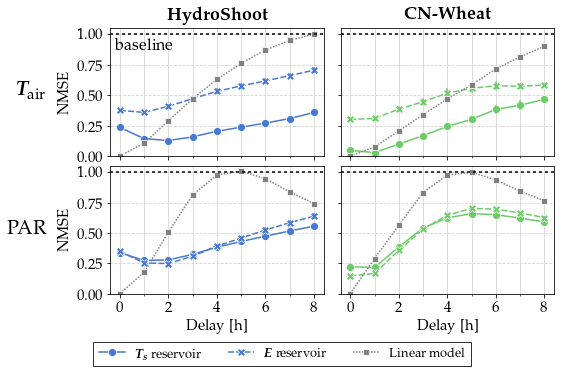

In [20]:
with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharey=True, sharex=True)
  colors = sns.color_palette()

  for row, axs_row, target in zip([0,1], axs, input_names):
    for col, ax, dataset in zip([0, 1], axs_row, datasets):
      
      # Data
      color = colors[col]
      plot_data = delay_scores.loc[
        (delay_scores.dataset_id == dataset) & 
        (delay_scores.target_id == target) &
        (delay_scores.reservoir_id.isin(reservoirs + [target_baseline_map[target]]))
      ]
      sns.lineplot(data=plot_data, x='delay', y='test_score', hue='reservoir_id', style='reservoir_id',
                   dashes=True, markers=True, ax=ax, markersize=8, err_style='bars', palette=[color, color, 'grey'])

      # Labeling
      # ax.set_title(f'{target} / {dataset}')
      ax.set(xlabel=r'Delay [\unit{h}]', ylabel='NMSE')
      if col == 0:
        ax.annotate(input_symbols[target], (-0.3, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=20)
      if row == 0:
        ax.annotate(f'\\textbf{{{dataset}}}', (0.5, 1.07), xycoords='axes fraction', ha='center', fontsize=18)

      # Axes
      ax.xaxis.set_major_locator(MultipleLocator(2))
      ax.xaxis.set_minor_locator(MultipleLocator(1))
      ax.grid(axis='x', linestyle='solid', color='lightgrey', which='both')
      ax.grid(axis='y', linestyle='dashed', color='lightgrey', which='both')
    
      ax.set_ylim(0, 1.05)
      ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
      ax.axhline(1, color='black', dashes=(2,2))
      if ax is axs.flatten()[0]:
        ax.annotate('baseline', (0.017, 0.83), fontsize=16, xycoords='axes fraction')

      # Cleanup
      if ax is axs.flatten()[0]:
        labels = [f"{res_symbols[l]} reservoir" for l in ax.get_legend_handles_labels()[1][:-1]] + ['Linear model']
        fig.legend(labels, loc='lower center', fancybox=False, shadow=False, ncol=3, 
                   frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.06), fontsize=13)
      ax.get_legend().remove()


  plt.tight_layout()
  plt.subplots_adjust(wspace=0.08, hspace=0.08)  
  plt.savefig('comp_delay_perf.png', dpi=200, facecolor='white', bbox_inches='tight')


### Polynomial

In [12]:
polynomial_scores = get_benchmark_scores('polynomial')
print(polynomial_scores.shape)

(2304, 13)


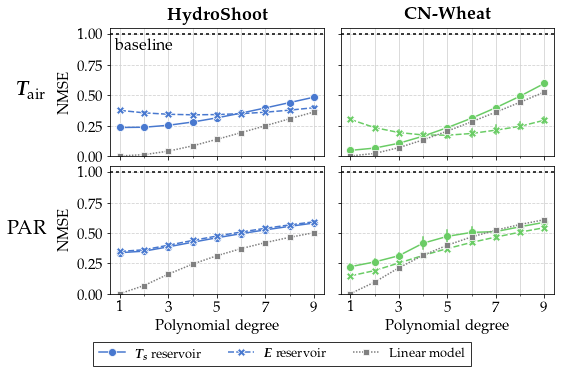

In [21]:
with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharey=True, sharex=True)
  colors = sns.color_palette()

  for row, axs_row, target in zip([0,1], axs, input_names):
    for col, ax, dataset in zip([0, 1], axs_row, datasets):
      
      # Data
      color = colors[col]
      plot_data = polynomial_scores.loc[
        (polynomial_scores.dataset_id == dataset) & 
        (polynomial_scores.target_id == target) &
        (polynomial_scores.reservoir_id.isin(reservoirs + [target_baseline_map[target]]))
      ]
      sns.lineplot(data=plot_data, x='exponent', y='test_score', hue='reservoir_id', style='reservoir_id',
                   dashes=True, markers=True, ax=ax, markersize=8, err_style='bars', palette=[color, color, 'grey'])

      # Labeling
      # ax.set_title(f'{target} / {dataset}')
      ax.set(xlabel=r'Polynomial degree', ylabel='NMSE')
      if col == 0:
        ax.annotate(input_symbols[target], (-0.3, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=20)
      if row == 0:
        ax.annotate(f'\\textbf{{{dataset}}}', (0.5, 1.07), xycoords='axes fraction', ha='center', fontsize=18)

      # Axes
      ax.xaxis.set_major_locator(FixedLocator([1, 3, 5, 7, 9]))
      ax.xaxis.set_minor_locator(MultipleLocator(1))
      ax.grid(axis='x', linestyle='solid', color='lightgrey', which='both')
      ax.grid(axis='y', linestyle='dashed', color='lightgrey', which='both')
    
      ax.set_ylim(0, 1.05)
      ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
      ax.axhline(1, color='black', dashes=(2,2))
      if ax is axs.flatten()[0]:
        ax.annotate('baseline', (0.017, 0.83), fontsize=16, xycoords='axes fraction')

      # Cleanup
      if ax is axs.flatten()[0]:
        labels = [f"{res_symbols[l]} reservoir" for l in ax.get_legend_handles_labels()[1][:-1]] + ['Linear model']
        fig.legend(labels, loc='lower center', fancybox=False, shadow=False, ncol=3, 
                   frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.06), fontsize=13)
      ax.get_legend().remove()


  plt.tight_layout()
  plt.subplots_adjust(wspace=0.08, hspace=0.08)  
  plt.savefig('comp_polynomial_perf.png', dpi=200, facecolor='white', bbox_inches='tight')


### NARMA

In [14]:
narma_scores = get_benchmark_scores('NARMA')
narma_scores.narma_n = narma_scores.narma_n.apply(lambda x: int(x))
print(narma_scores.shape)

(1536, 13)


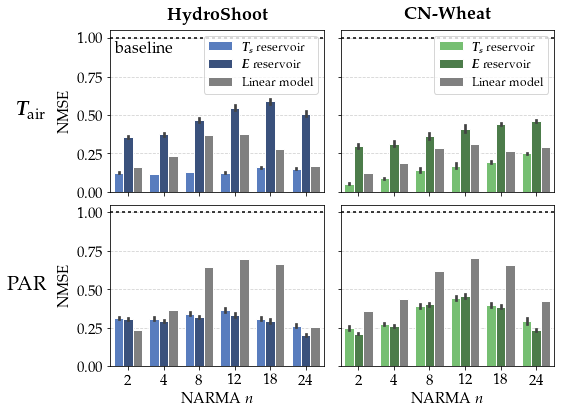

In [15]:
with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
  colors = sns.color_palette()

  for row, axs_row, target in zip([0,1], axs, input_names):
    for col, ax, dataset in zip([0, 1], axs_row, datasets):
      
      # Data
      color = colors[col]
      color_alt = list(map(lambda x: 0.65 * x, color))
      plot_data = narma_scores.loc[
        (narma_scores.dataset_id == dataset) & 
        (narma_scores.target_id == target) &
        (narma_scores.reservoir_id.isin(reservoirs + [target_baseline_map[target]]))
      ]
      # sns.lineplot(data=plot_data, x='narma_n', y='test_score', hue='reservoir_id', style='reservoir_id',
                  #  dashes=True, markers=True, ax=ax, markersize=8, err_style='bars', palette=[color, color, 'grey'])

      sns.barplot(data=plot_data, x='narma_n', y='test_score', hue='reservoir_id', ax=ax, 
                  palette=[color, color_alt, 'grey'], edgecolor="white")

      ax.set(xlabel=None, ylabel=None)
      # Labeling
      if col == 0:
        ax.set(ylabel='NMSE')
        ax.annotate(input_symbols[target], (-0.3, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=20)
      if row == 0:
        ax.annotate(f'\\textbf{{{dataset}}}', (0.5, 1.07), xycoords='axes fraction', ha='center', fontsize=18)
      if row == 1:
        ax.set(xlabel=r'NARMA $n$')


      # Axes
      ax.set_axisbelow(True)
      ax.grid(axis='y', linestyle='dashed', color='lightgrey', which='both')
    
      ax.set_ylim(0, 1.05)
      ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
      ax.axhline(1, color='black', dashes=(2,2))
      if ax is axs.flatten()[0]:
        ax.annotate('baseline', (0.017, 0.86), fontsize=16, xycoords='axes fraction')

      # Cleanup
      if row == 0:
        handles, labels = ax.get_legend_handles_labels()
        labels = [f"{res_symbols[l]} reservoir" for l in ax.get_legend_handles_labels()[1][:-1]] + ['Linear model']
        ax.legend(handles, labels, loc='upper right')
      else:
        ax.get_legend().remove()


  plt.tight_layout()
  plt.subplots_adjust(wspace=0.08, hspace=0.08)  
  plt.savefig('comp_NARMA_perf.png', dpi=200, facecolor='white', bbox_inches='tight')
